In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import datasets, layers, models
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
import urllib.request

url = "https://www.vcl.fer.hr/comofod/comofod_small.rar"

filename = "comofod_small.rar"

urllib.request.urlretrieve(url, filename)

print("Dataset Downloaded Successfully!")

!pip install patool

import patoolib
patoolib.extract_archive(filename, outdir="https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link")

print("Dataset Extracted Successfully!")


Dataset Downloaded Successfully!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 4.8 MB/s eta 0:00:00


INFO patool: Extracting comofod_small.rar ...
INFO:patool:Extracting comofod_small.rar ...
INFO patool: ... creating output directory `https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link'.
INFO:patool:... creating output directory `https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link'.
INFO patool: running /usr/bin/unrar x -- /content/comofod_small.rar
INFO:patool:running /usr/bin/unrar x -- /content/comofod_small.rar
INFO patool:     with cwd='https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link', input=''
INFO:patool:    with cwd='https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link', input=''
INFO patool: ... comofod_small.rar extracted to `https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link'.
INFO:patool:... comofod_small.rar extracted to `https://drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_

Dataset Extracted Successfully!


In [ ]:
import os
import shutil
from PIL import Image
import numpy as np

# Define the source folder where your images are located
source_folder = '/content/https:/drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link/CoMoFoD_small_v2'
# Define the target folder where the images will be organized into class-based subfolders
target_folder = '/content/https:/drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link/CoMoFoD_small_v2'

# Define a function to determine the class label from the filename
def extract_class_label(filename):
    if 'O' in filename:
        return 'original'
    elif 'F' in filename:
        return 'forged'
    else:
        return None  # Ignore other classes

# Create target folders for only the relevant classes
for label in ['original', 'forged']:
    class_folder = os.path.join(target_folder, label)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

# Loop through each image in the source folder
for image_name in os.listdir(source_folder):
    # Get the full path of the image
    image_path = os.path.join(source_folder, image_name)

    # Ensure the file is an image by checking its extension (optional)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Extract the class label from the filename
        class_label = extract_class_label(image_name)

        if class_label:  # Move only relevant images
            # Create the target class folder if it doesn't exist
            class_folder = os.path.join(target_folder, class_label)

            # Move the image to the class folder
            shutil.move(image_path, os.path.join(class_folder, image_name))

print("Images have been filtered and organized into class folders.")


Images have been filtered and organized into class folders.


###Image Preprocessing
*Converting to rgb/resize/normalize*

<ipython-input-5-94f2c4f695df>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)


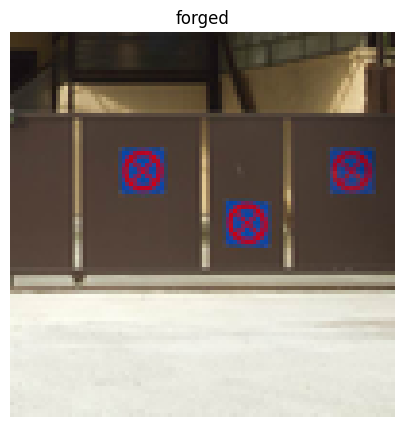

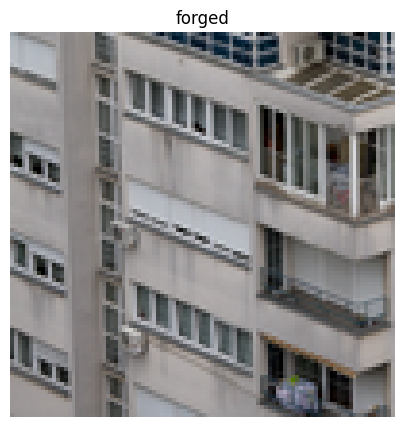

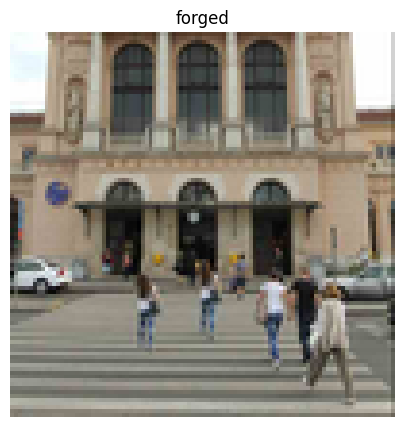

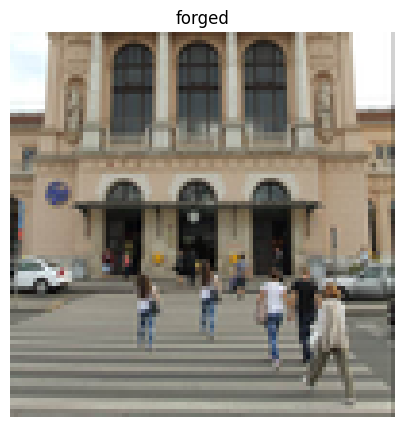

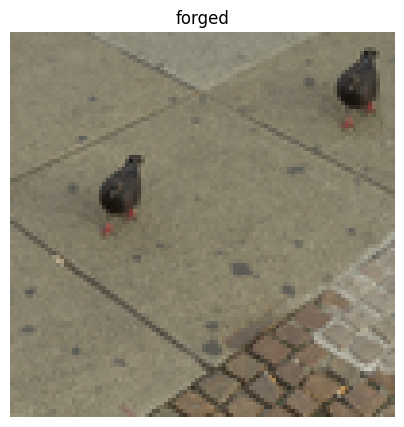

In [ ]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def resize_and_crop_image_pillow(image_path, target_size=(100, 100)):
    with Image.open(image_path) as img:
        # Resize while maintaining aspect ratio
        img.thumbnail(target_size, Image.ANTIALIAS)

        # Create a square canvas
        canvas = Image.new('RGB', target_size, (255, 255, 255))

        # Calculate position to paste the resized image
        paste_x = (target_size[0] - img.width) // 2
        paste_y = (target_size[1] - img.height) // 2

        # Paste the resized image onto the canvas
        canvas.paste(img, (paste_x, paste_y))

        # Convert to numpy array
        cropped_image = np.array(canvas)

        # Normalize the image
        cropped_image_normalized = cropped_image / 255.0

    return cropped_image_normalized

# Define the path to the main folder
main_folder_path = '/content/https:/drive.google.com/drive/folders/1LQEaFqJNut5YGHno-zosWFRaix3O_iQw?usp=drive_link/CoMoFoD_small_v2'

# List all subfolders (classes) in the main folder
class_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]

# Dictionary to hold images and their labels
images = []
labels = []

# Iterate through each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(main_folder_path, class_folder)

    # List all image files in the class folder
    image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Iterate through each image file
    for image_file in image_files[:500]:
        image_path = os.path.join(class_folder_path, image_file)
        processed_image = resize_and_crop_image_pillow(image_path)

        # Append the image and its label
        images.append(processed_image)
        labels.append(class_folder)  # Label is the name of the class folder

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Display some images and their labels
for i in range(min(5, len(images))):  # Display up to 5 images
    plt.figure(figsize=(5, 5))
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    plt.show()

* ensures that images are uniformly sized and normalized

###Modelling

In [ ]:
# Data preparation
X = np.array(images)
y = np.array(labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(label_encoder.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)


X_train, X_testV, y_train, y_testV = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testV, y_testV, test_size=0.5, random_state=42)



# Define the CNN model
def create_cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='tanh', input_shape=(100, 100, 3)))  # Adjusted input_shape
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
    cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='tanh'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=128, activation='tanh'))
    cnn_model.add(Dropout(rate=0.3))
    cnn_model.add(Dense(units=num_classes, activation='softmax'))  # Adjusted for num_classes
    return cnn_model

# Instantiate the CNN model
cnn_model = create_cnn_model()

# Set a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
fine_tune_lr = 1e-5
cnn_model.compile(optimizer = Adam(fine_tune_lr, beta_1=0.9, beta_2=0.999)
, loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the CNN model with additional training
history_cnn_finetune = cnn_model.fit(X_train, y_train, batch_size=10, epochs=10, validation_data=(X_val, y_val))

# Print the model summary
cnn_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.4812 - loss: 0.8943 - val_accuracy: 0.5900 - val_loss: 0.6875
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 420ms/step - accuracy: 0.5236 - loss: 0.8133 - val_accuracy: 0.5800 - val_loss: 0.7033
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - accuracy: 0.6385 - loss: 0.6976 - val_accuracy: 0.5900 - val_loss: 0.6699
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.6150 - loss: 0.6957 - val_accuracy: 0.6100 - val_loss: 0.6884
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 484ms/step - accuracy: 0.6530 - loss: 0.6256 - val_accuracy: 0.6300 - val_loss: 0.6460
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 450ms/step - accuracy: 0.6638 - loss: 0.6079 - val_accuracy: 0.6000 - val_loss: 0.6543
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 522ms/step - accuracy: 0.6963 - loss: 0.5902 - val_accuracy: 0.6700 - val_loss: 0.6153
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 466ms/step - accuracy: 0.6926 - loss: 0.5745 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,298,056 (43.10 MB)

 Trainable params: 3,765,890 (14.37 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 7,531,782 (28.73 MB)

In [ ]:
# Data preparation
X = np.array(images)
y = np.array(labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(label_encoder.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)


X_train, X_testV, y_train, y_testV = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testV, y_testV, test_size=0.5, random_state=42)



# Define the CNN model
def create_cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))  # Adjusted input_shape
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=128, activation='relu'))
    cnn_model.add(Dropout(rate=0.5))
    cnn_model.add(Dense(units=num_classes, activation='softmax'))  # Adjusted for num_classes
    return cnn_model

# Instantiate the CNN model
cnn_model = create_cnn_model()

# Set a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
fine_tune_lr = 1e-5
cnn_model.compile(optimizer=Adam(learning_rate=fine_tune_lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the CNN model with additional training
history_cnn_finetune = cnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

# Print the model summary
cnn_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 936ms/step - accuracy: 0.4895 - loss: 1.4998 - val_accuracy: 0.4500 - val_loss: 0.7050
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 823ms/step - accuracy: 0.5520 - loss: 1.0848 - val_accuracy: 0.4000 - val_loss: 0.6974
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 832ms/step - accuracy: 0.5771 - loss: 0.8524 - val_accuracy: 0.6300 - val_loss: 0.6849
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 863ms/step - accuracy: 0.6129 - loss: 0.8708 - val_accuracy: 0.6000 - val_loss: 0.6830
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6399 - loss: 0.7337 - val_accuracy: 0.5800 - val_loss: 0.6905
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 841ms/step - accuracy: 0.6657 - loss: 0.6598 - val_accuracy: 0.5800 - val_loss: 0.7135
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 898ms/step - accuracy: 0.7117 - loss: 0.5618 - val_accuracy: 0.5800 - val_loss: 0.7254
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 847ms/step - accuracy: 0.6972 - loss: 0.5906 - val_accurac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,333,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,060,808 (49.82 MB)

 Trainable params: 4,353,538 (16.61 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 8,707,078 (33.21 MB)

In [ ]:
# Define the CNN model
def create_cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))  # Adjusted input_shape
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=128, activation='relu'))
    cnn_model.add(Dropout(rate=0.5))
    cnn_model.add(Dense(units=num_classes, activation='softmax'))  # Adjusted for num_classes
    return cnn_model

# Instantiate the CNN model
cnn_model = create_cnn_model()

# Set a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
fine_tune_lr = 1e-5
cnn_model.compile(optimizer=Adam(learning_rate=fine_tune_lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the CNN model with additional training
history_cnn_finetune = cnn_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

# Print the model summary
cnn_model.summary()



Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 919ms/step - accuracy: 0.4411 - loss: 1.6980 - val_accuracy: 0.5500 - val_loss: 0.6884
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 899ms/step - accuracy: 0.5804 - loss: 1.0124 - val_accuracy: 0.4900 - val_loss: 0.6926
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 903ms/step - accuracy: 0.5829 - loss: 0.8805 - val_accuracy: 0.5200 - val_loss: 0.6906
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.5915 - loss: 0.8250 - val_accuracy: 0.5500 - val_loss: 0.6884
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 908ms/step - accuracy: 0.6428 - loss: 0.7372 - val_accuracy: 0.6000 - val_loss: 0.6787
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 829ms/step - accuracy: 0.6648 - loss: 0.6679 - val_accuracy: 0.5900 - val_loss: 0.6864
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 888ms/step - accuracy: 0.7030 - loss: 0.5822 - val_accuracy: 0.5800 - val_loss: 0.7031
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 895ms/step - accuracy: 0.7598 - loss: 0.5016 - val_accu

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,333,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,060,808 (49.82 MB)

 Trainable params: 4,353,538 (16.61 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 8,707,078 (33.21 MB)

#CNN & LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, BatchNormalization, Dropout

# Assuming you want sequences of length 10
sequence_length = 10

# Reshape X_train, X_val, X_test to the appropriate shape
X_train2 = X_train.reshape((-1, sequence_length, 100, 100, 3))
X_val2 = X_val.reshape((-1, sequence_length, 100, 100, 3))
X_test2 = X_test.reshape((-1, sequence_length, 100, 100, 3))

y_train2 = y_train[sequence_length-1::sequence_length]  # Adjust y_train to match sequence length
y_val2 = y_val[sequence_length-1::sequence_length]      # Adjust y_val to match sequence length
y_test2 = y_test[sequence_length-1::sequence_length]    # Adjust y_test to match sequence length


def create_cnn_lstm_model(num_classes):
    model = Sequential()

    # Use TimeDistributed to apply CNN to each frame of the sequence
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=(10, 100, 100, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add an additional LSTM layer with dropout
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))  # Add a dense layer before the output
    model.add(Dropout(0.5))  # Additional dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate and compile the model with a lower learning rate
model = create_cnn_lstm_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the CNN-LSTM model with additional training
history_cnn_lstm_finetune = model.fit(X_train2, y_train2, batch_size=16, epochs=20, validation_data=(X_val2, y_val2))

# Print the model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 158s 27s/step - accuracy: 0.4974 - loss: 0.6997 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 189s 26s/step - accuracy: 0.3729 - loss: 0.7396 - val_accuracy: 0.5000 - val_loss: 0.7009
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 136s 28s/step - accuracy: 0.5790 - loss: 0.6779 - val_accuracy: 0.5000 - val_loss: 0.7134
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 148s 28s/step - accuracy: 0.5141 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.7177
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 203s 29s/step - accuracy: 0.6592 - loss: 0.6503 - val_accuracy: 0.5000 - val_loss: 0.7189
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 203s 29s/step - accuracy: 0.6524 - loss: 0.6558 - val_accuracy: 0.5000 - val_loss: 0.7227
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 201s 29s/step - accuracy: 0.6194 - loss: 0.6381 - val_accuracy: 0.5000 - val_loss: 0.7309
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 208s 30s/step - accuracy: 0.5439 - loss: 0.6863 - val_accuracy: 0.5000 - val_loss:

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 100, 100, 64)    │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 100, 100, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 50, 50, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 50, 50, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 50, 50, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 25, 25, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 80000)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 50)              │      16,010,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,329,864 (184.36 MB)

 Trainable params: 16,109,826 (61.45 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 32,219,654 (122.91 MB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, BatchNormalization, Dropout

# Assuming you want sequences of length 10
sequence_length = 10

# Reshape X_train, X_val, X_test to the appropriate shape
X_train3 = X_train.reshape((-1, sequence_length, 100, 100, 3))
X_val3 = X_val.reshape((-1, sequence_length, 100, 100, 3))
X_test3 = X_test.reshape((-1, sequence_length, 100, 100, 3))

y_train3 = y_train[sequence_length-1::sequence_length]  # Adjust y_train to match sequence length
y_val3 = y_val[sequence_length-1::sequence_length]      # Adjust y_val to match sequence length
y_test3 = y_test[sequence_length-1::sequence_length]    # Adjust y_test to match sequence length


def create_cnn_lstm_model(num_classes):
    model = Sequential()

    # Use TimeDistributed to apply CNN to each frame of the sequence
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=(10, 100, 100, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add an additional LSTM layer with dropout
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))  # Add a dense layer before the output
    model.add(Dropout(0.5))  # Additional dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate and compile the model with a lower learning rate
model = create_cnn_lstm_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the CNN-LSTM model with additional training
history_cnn_lstm_finetune = model.fit(X_train3, y_train3, batch_size=16, epochs=19, validation_data=(X_val3, y_val3))

# Print the model summary
model.summary()



Epoch 1/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 157s 29s/step - accuracy: 0.4630 - loss: 0.7202 - val_accuracy: 0.7000 - val_loss: 0.6914
Epoch 2/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 29s/step - accuracy: 0.4545 - loss: 0.7249 - val_accuracy: 0.4000 - val_loss: 0.6926
Epoch 3/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 198s 28s/step - accuracy: 0.5509 - loss: 0.6969 - val_accuracy: 0.6000 - val_loss: 0.6943
Epoch 4/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 28s/step - accuracy: 0.5526 - loss: 0.6836 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 5/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 28s/step - accuracy: 0.5854 - loss: 0.6783 - val_accuracy: 0.5000 - val_loss: 0.6962
Epoch 6/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 28s/step - accuracy: 0.6224 - loss: 0.6690 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 7/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 155s 31s/step - accuracy: 0.5691 - loss: 0.6503 - val_accuracy: 0.4000 - val_loss: 0.6949
Epoch 8/19
5/5 ━━━━━━━━━━━━━━━━━━━━ 189s 27s/step - accuracy: 0.6981 - loss: 0.6312 - val_accuracy: 0.4000 - val_loss:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_7 (TimeDistributed) │ (None, 10, 100, 100, 64)    │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 100, 100, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 50, 50, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 10, 50, 50, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 10, 50, 50, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 10, 25, 25, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 10, 80000)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 50)              │      16,010,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,329,864 (184.36 MB)

 Trainable params: 16,109,826 (61.45 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 32,219,654 (122.91 MB)

# Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Confusion matrix:
[[46  8]
 [ 3 43]]
Accuracy: 0.8900


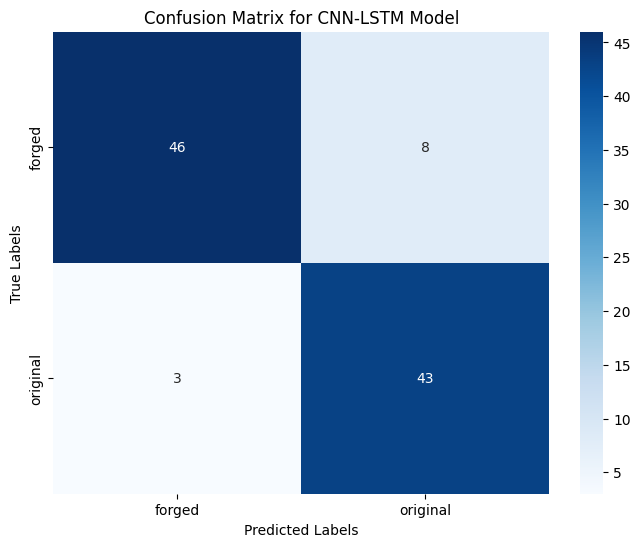

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict with the model
y_pred_probs = cnn_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_classes = np.argmax(y_test, axis=1)

# Check if y_true_classes has the same length as y_pred_classes
if len(y_true_classes) != len(y_pred_classes):
    raise ValueError("Length of true labels and predicted labels do not match.")

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"Confusion matrix:\n{cm}")

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN-LSTM Model')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion matrix:
[[3 2]
 [2 3]]
Accuracy: 0.6000


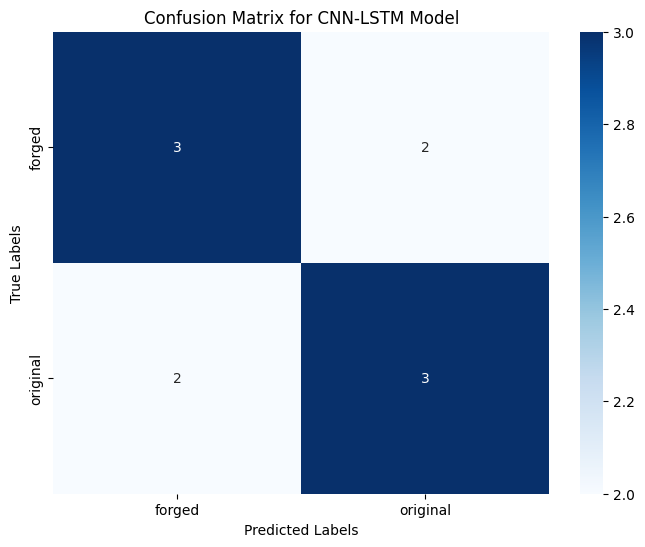

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict with the model
y_pred_probs2 = model.predict(X_test2)

# Convert predictions to class labels
y_pred_classes2 = np.argmax(y_pred_probs2, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_classes2 = np.argmax(y_test2, axis=1)

# Check if y_true_classes has the same length as y_pred_classes
if len(y_true_classes2) != len(y_pred_classes2):
    raise ValueError("Length of true labels and predicted labels do not match.")

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes2, y_pred_classes2)
print(f"Confusion matrix:\n{cm}")

# Calculate accuracy
accuracy = accuracy_score(y_true_classes2, y_pred_classes2)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN-LSTM Model')
plt.show()
